In [40]:
import pandas as pd
import numpy as np

df = pd.read_csv('../data/sismos.csv', encoding='latin1')
data = pd.read_csv('../data/sismos.csv', encoding='latin1')

df.replace('en revision', np.nan, inplace=True)
df.replace('no calculable', np.nan, inplace=True)
df['Fecha_Hora']=pd.to_datetime(df['Fecha'] + ' '+ df['Hora'])
df_labels = pd.DataFrame(df['Profundidad'],columns=['Profundidad'])
df.drop(columns=['Fecha','Hora','Fecha_UTC','Hora_UTC','Estatus','Profundidad'], inplace=True, axis=1)
df_num = df.drop(['Localizacion','Fecha_Hora'], axis=1)


/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (2,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [41]:
import re
regex = '^.*km al .*de .*,'dtg
x
local_sub = lambda x: re.sub(regex,'',x)

df['Localizacion']=df['Localizacion'].apply(local_sub)
df['Localizacion'].value_counts()

median = df['Magnitud'].median()
df['Magnitud'].fillna(median,inplace=True)
df_num_attr =list(df_num)
df_one_attr = ['Localizacion']

median = df_labels['Profundidad'].median()
df_labels['Profundidad'].fillna(median, inplace=True)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

num_pipeline = Pipeline([('selector',DataFrameSelector(df_num_attr)),('imputer',Imputer(strategy='median')),])
cat_pipeline = Pipeline([('selector',DataFrameSelector(df_one_attr)),('one_encoder',OneHotEncoder(sparse=False)),])
full_pipeline = FeatureUnion(transformer_list=[('num_pipeline',num_pipeline),('cat_pipeline',cat_pipeline),])

earthquakes_prepared = full_pipeline.fit_transform(df)
earthquakes_prepared

#imputer = Imputer(strategy='median')
##imputer.fit(df_num)
#imputer.statistics_
##df_num = pd.DataFrame(imputer.transform(df_num), columns=df_num.columns)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


array([[   7.4 ,   20.  , -105.  , ...,    0.  ,    0.  ,    0.  ],
       [   6.9 ,   20.  , -105.  , ...,    0.  ,    0.  ,    0.  ],
       [   6.9 ,   25.  , -110.  , ...,    0.  ,    0.  ,    0.  ],
       ...,
       [   2.4 ,   19.19, -104.24, ...,    0.  ,    0.  ,    0.  ],
       [   3.3 ,   19.34, -104.49, ...,    0.  ,    0.  ,    0.  ],
       [   3.5 ,   16.39,  -94.91, ...,    0.  ,    0.  ,    0.  ]])

In [42]:
from sklearn.linear_model import LinearRegression

linear_reg = LinearRegression()
linear_reg.fit(earthquakes_prepared,df_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [43]:
some_data = df.iloc[:5]
some_labels = df_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

linear_reg.predict(some_data_prepared)

array([[69.0890875 ],
       [64.66505231],
       [34.04523802],
       [49.96771656],
       [67.20166276]])

In [44]:
from sklearn.metrics import mean_squared_error

earthquake_predictions = linear_reg.predict(earthquakes_prepared)
lin_mse = mean_squared_error(earthquake_predictions, df_labels)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

29.047939059495985

In [45]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(earthquakes_prepared,df_labels)
tree_predictions = tree_reg.predict(earthquakes_prepared)
lin_mse = mean_squared_error(tree_predictions, df_labels)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

3.564526993046849

In [46]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, earthquakes_prepared, df_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

def display_scores(scores):
    print('Scores:',scores)
    print('Mean:',scores.mean())
    print('Standard Deviation:',scores.std())

display_scores(tree_rmse_scores)

Scores: [35.87016131 37.6122951  32.43483694 31.07662253 28.94821864 27.37606909
 27.07675461 27.0890647  30.62023239 25.36730229]
Mean: 30.347155760032205
Standard Deviation: 3.8097893377885286


In [47]:
scores_lin = cross_val_score(linear_reg, earthquakes_prepared, df_labels, scoring='neg_mean_squared_error', cv=10)
linear_reg_scores = np.sqrt(-scores_lin)
display_scores(linear_reg_scores)

Scores: [3.32295558e+01 3.24719635e+01 3.34129774e+01 3.17219108e+01
 2.91519005e+01 2.92381005e+01 2.81419334e+01 1.87052619e+10
 2.75521113e+01 2.28981901e+01]
Mean: 1870526220.167485
Standard Deviation: 5611578571.229575


In [24]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(earthquakes_prepared, df_labels)

scores_forest = cross_val_score(forest_reg, earthquakes_prepared, df_labels, scoring="neg_mean_squared_error", cv=10)
forest_reg_scores = np.sqrt(-scores_forest)
display_scores(forest_reg_scores)

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using

Scores: [28.32619314 31.54480555 26.34487538 24.15686203 22.05503967 21.56415212
 20.51388532 20.25680866 24.10141483 19.59752196]
Mean: 23.846155865507065
Standard Deviation: 3.690517639052877


In [25]:
some_data.head()

,Magnitud,Latitud,Longitud,Localizacion,Fecha_Hora
0,7.4,20.00,-105.00,JAL,1900-01-20 00:33:30
1,6.9,20.00,-105.00,JAL,1900-05-16 14:12:00
2,6.9,25.00,-110.00,BCS,1901-03-05 04:45:00
3,7.0,26.00,-110.00,SIN,1901-12-08 20:17:00
4,7.0,17.62,-99.72,GRO,1902-01-16 17:19:00


In [26]:
data.head()

,Fecha,Hora,Magnitud,Latitud,Longitud,Profundidad,Localizacion,Fecha_UTC,Hora_UTC,Estatus
0,1900-01-20,00:33:30,7.4,20.00,-105.00,33.0,"71 km al NOROESTE de AUTLAN DE NAVARRO, JAL",1900-01-20,06:33:30,revisado
1,1900-05-16,14:12:00,6.9,20.00,-105.00,33.0,"71 km al NOROESTE de AUTLAN DE NAVARRO, JAL",1900-05-16,20:12:00,revisado
2,1901-03-05,04:45:00,6.9,25.00,-110.00,33.0,"100 km al NORESTE de LA PAZ, BCS",1901-03-05,10:45:00,revisado
3,1901-12-08,20:17:00,7.0,26.00,-110.00,33.0,"83 km al OESTE de AHOME, SIN",1901-12-09,02:17:00,revisado
4,1902-01-16,17:19:00,7.0,17.62,-99.72,33.0,"21 km al OESTE de ZUMPANGO DEL RIO, GRO",1902-01-16,23:19:00,revisado


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10cab8d30>,
      dtype=object)

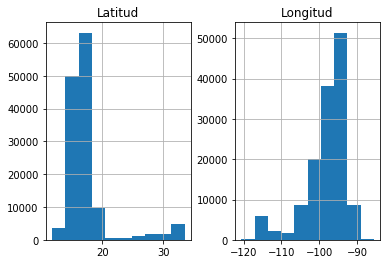

In [29]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

data.hist()

In [39]:
pd.to_numeric(data['Magnitud'])
data.plot(x='Fecha',y='Magnitud',figsize=(20,15))

Fecha                                   1974-01-10
Hora                                      08:35:40
Magnitud                             no calculable
Latitud                                      17.58
Longitud                                   -103.11
Profundidad                                   33.0
Localizacion    97 km al SUROESTE de LA MIRA, MICH
Fecha_UTC                               1974-01-10
Hora_UTC                                  14:35:40
Estatus                                   revisado
Name: 140, dtype: object